In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dig1 = 1
dig2 = 5

train = np.loadtxt("ZipDigits.train",delimiter=" ",usecols=range(0, 257))
test = np.loadtxt("ZipDigits.test",delimiter=" ",usecols=range(0, 257))

fil_train = []
fil_test = []

fil_train = train[(train[:, 0] == dig1) | (train[:, 0] == dig2)]
fil_test = test[(test[:, 0] == dig1) | (test[:, 0] == dig2)]

fil_train[:, 0] = np.where(fil_train[:, 0] == 1, dig1, -1)
fil_test[:, 0] = np.where(fil_test[:, 0] == 1, dig1, -1)

In [2]:
df_train = pd.DataFrame(fil_train)
df_test = pd.DataFrame(fil_test)

In [3]:
intensities_dig1 = []
intensities_dig2 = []
symmetry_dig1 = []
symmetry_dig2 = []
intensities = []
symmetry = []
y = [] 

for i in range(df_train.shape[0]):
        pix = np.array(df_train.iloc()[i])
        avg = np.mean(pix[1:])
        arr = np.array(pix[1:])
        image_2d = arr.reshape(16, 16)
        upper_half = image_2d[:8,:]
        lower_half = image_2d[8:,:]
        lower_half_flipped = np.flipud(lower_half)
        avg1 = np.mean(np.absolute(upper_half - lower_half_flipped))
        intensities.append(avg)
        symmetry.append(avg1)
        if(df_train[0][i]==1):
            intensities_dig1.append(avg)
            symmetry_dig1.append(avg1)
            y.append(1)
        else:
            intensities_dig2.append(avg)
            symmetry_dig2.append(avg1)
            y.append(-1)
        
labels = np.where(df_train[0]==1, "red", "blue")
df_train.insert(0,"Labels",labels)
df_train.insert(0,"y",y)
df_train.insert(0,"x2",symmetry)
df_train.insert(0,"x1",intensities)
df_train.insert(0,"x0",[1]*df_train.shape[0])

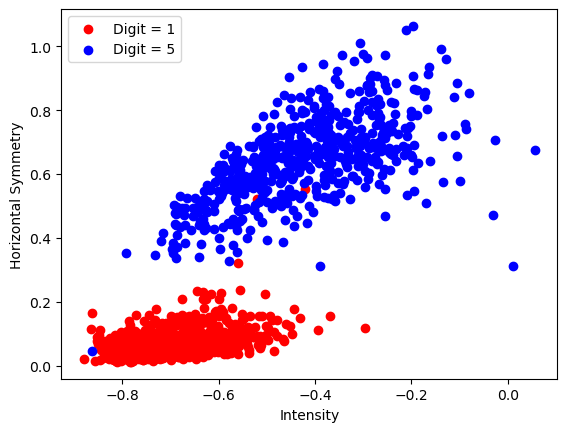

In [4]:
plt.scatter(intensities_dig1, symmetry_dig1, c="red", label="Digit = {}".format(dig1))
plt.scatter(intensities_dig2, symmetry_dig2, c="blue", label="Digit = {}".format(dig2))

plt.xlabel("Intensity")
plt.ylabel("Horizontal Symmetry")
plt.legend()
plt.show()

In [5]:
data = pd.DataFrame(df_train.iloc[:,:4])
data_train = data

In [6]:
def plot_graph(w, tit):
    axes = plt.gca()
    color = np.where(data["y"]==1, "red", "blue")
    plt.scatter(list(data['x1']), list(data['x2']), c=color)

    x_vals = np.array(axes.get_xlim())
    y_vals = []
    for i in x_vals:
        y = -w[0]/w[2] - (w[1]/w[2] * i)
        y_vals.append(y)
    plt.plot(x_vals, y_vals, '--')
    plt.title(tit)
    plt.show()

In [7]:
def check_missing_points(w):
    X = data[['x0', 'x1', 'x2']].values
    hypo_y = np.sign(np.dot(X, w))
    mismatched_indices = np.where(hypo_y != data["y"].values)[0]
    return mismatched_indices.tolist()

def pocket_algo(w):
    global max_itr
    w_best = tuple(w)
    miss_points = tuple(check_missing_points(w_best))
    w_best_points = len(miss_points)
    print(w_best_points)
    l_data = len(data)
    #Ein = []
    n = max_itr # maxnumber of iterations
    out_itr = n
    for i in range(n):
        j = miss_points[0]
        w[0] = w[0] + data["y"][j]*data["x0"][j]
        w[1] = w[1] + data["y"][j]*data["x1"][j]
        w[2] = w[2] + data["y"][j]*data["x2"][j]
        
        miss_points = tuple(check_missing_points(w))
        w_points = len(miss_points)
        #Ein.append(w_best_points/l_data)

        if(w_points < w_best_points):
            w_best = tuple(w)
            w_best_points = w_points
            out_itr = i
        
        if(w_points == 0):
            w_best = tuple(w)
            w_best_points = w_points
            break

    plot_graph(w_best, "Pocket Algorithm")
    print("Final Weights (Pocket):",w_best, "Number of Missclassified points:", w_best_points, "Got Final Weights at iteration", out_itr)
    print("In Sample Error is", w_best_points/l_data*100, "%")
    return w_best

In [8]:
def check_miss_points(w):
    
    X = data[['x0', 'x1', 'x2']].values
    hypo_y = np.sign(np.dot(X, w))
    mismatched_indices = np.where(hypo_y != data["y"].values)[0]
    miss_list = mismatched_indices.tolist()
    len_miss_list = len(miss_list)
    if(len_miss_list>0):
        return True, miss_list[0]
    else:
        return False, -10

def perceptron_algo(w):
    flag, p_miss = check_miss_points(w)
    i = 0
    while flag:
        w[0] = w[0] + data["y"][p_miss]*data["x0"][p_miss]
        w[1] = w[1] + data["y"][p_miss]*data["x1"][p_miss]
        w[2] = w[2] + data["y"][p_miss]*data["x2"][p_miss]
        flag, p_miss = check_miss_points(w)
        if(i>1000):
            print("Perceptron Algorithm: The data is not linearly seperable or has some noisy data.")
            break
        i+=1
    plot_graph(w, "Perceptron")
    miss_points = check_missing_points(w)
    print("Final Weights (Perceptron):", w, "iterations:", i, "Number of Missclassified Points:", len(miss_points))
    return w

In [9]:
def linearRegression(X,Y):
    XT = np.transpose(X)
    XtX = np.matmul(XT,X)
    X_inv = np.linalg.inv(XtX)
    X_pi = np.matmul(X_inv,XT)
    W = np.matmul(X_pi,Y)
    
    miss_points = check_missing_points(W)
    plot_graph(W, "Linear Regression")
    print("Final Weights (Linear Regression):", W, "Number of Missclassified Points:", len(miss_points))
    return W

Perceptron Algorithm: The data is not linearly seperable or has some noisy data.


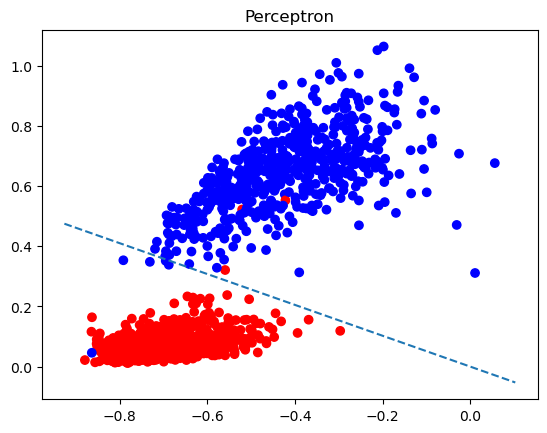

Final Weights (Perceptron): [0, -1.333730468749991, -2.6026796875000557] iterations: 1001 Number of Missclassified Points: 8


In [10]:
w = [0,0,0]
w_final_percep = perceptron_algo(w)

The data is not linearly seperable still plotting the best possible result using perceptron.

556


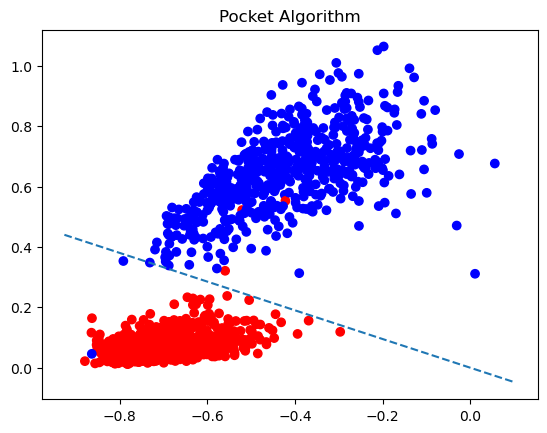

Final Weights (Pocket): (0, -0.8827734374999997, -1.8583906250000002) Number of Missclassified points: 5 Got Final Weights at iteration 22
In Sample Error is 0.3203074951953876 %


In [11]:
w = [1,1,1]
max_itr = 1000
w_final_pock = pocket_algo(w)

In [12]:
intensities_dig1 = []
intensities_dig2 = []
symmetry_dig1 = []
symmetry_dig2 = []
intensities = []
symmetry = []
y = [] 

for i in range(df_test.shape[0]):
        pix = np.array(df_test.iloc()[i])
        avg = np.mean(pix[1:])
        arr = np.array(pix[1:])
        image_2d = arr.reshape(16, 16)
        upper_half = image_2d[:8,:]
        lower_half = image_2d[8:,:]
        lower_half_flipped = np.flipud(lower_half)
        avg1 = np.mean(np.absolute(upper_half - lower_half_flipped))
        intensities.append(avg)
        symmetry.append(avg1)
        if(df_test[0][i]==1):
            intensities_dig1.append(avg)
            symmetry_dig1.append(avg1)
            y.append(1)
        else:
            intensities_dig2.append(avg)
            symmetry_dig2.append(avg1)
            y.append(-1)
        
labels = np.where(df_test[0]==1, "red", "blue")
df_test.insert(0,"Labels",labels)
df_test.insert(0,"y",y)
df_test.insert(0,"x2",symmetry)
df_test.insert(0,"x1",intensities)
df_test.insert(0,"x0",[1]*df_test.shape[0])

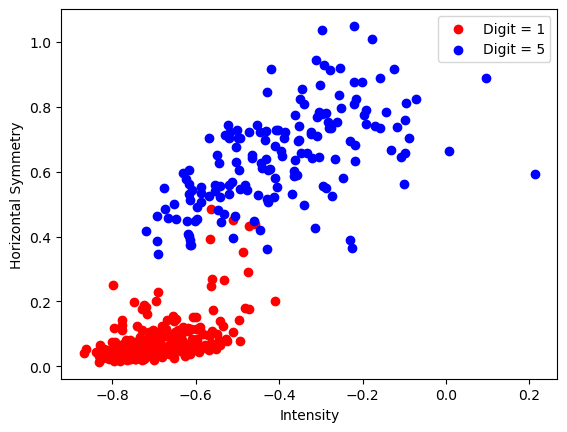

In [13]:
plt.scatter(intensities_dig1, symmetry_dig1, c="red", label="Digit = {}".format(dig1))
plt.scatter(intensities_dig2, symmetry_dig2, c="blue", label="Digit = {}".format(dig2))

plt.xlabel("Intensity")
plt.ylabel("Horizontal Symmetry")
plt.legend()
plt.show()

In [14]:
data = pd.DataFrame(df_test.iloc[:,:4])
data_test = data

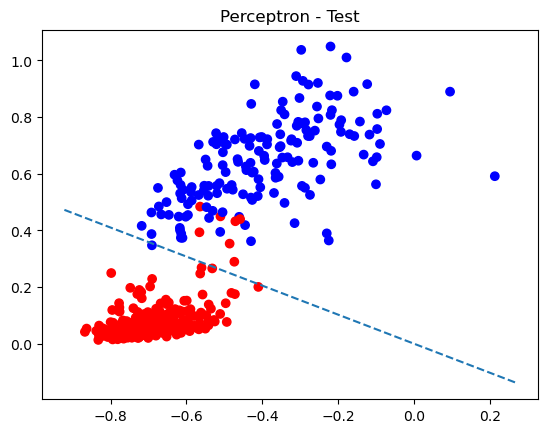

In Sample Error is 1.8867924528301887 %


In [15]:
plot_graph(w_final_percep, "Perceptron - Test")
miss_points = check_missing_points(w_final_percep)
ein_percept_test = len(miss_points)/len(data)*100
print("In Sample Error is", ein_percept_test, "%")

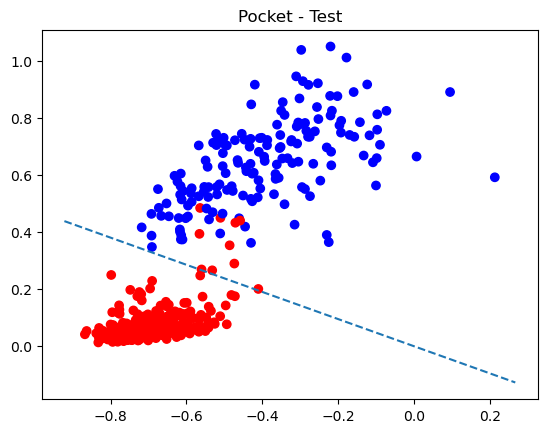

Test data in Sample Error is 2.358490566037736 %


In [16]:
plot_graph(w_final_pock, "Pocket - Test")
miss_points = check_missing_points(w_final_pock)
ein_pocket_test = len(miss_points)/len(data)*100
print("Test data in Sample Error is", ein_pocket_test, "%")

In [17]:
print("Ein for perceptron on test dataset is", ein_percept_test)
print("Ein for pocket on test dataset is", ein_pocket_test)
print("The data is noisy so we cant rely on the output of Perceptron, thus only acceptable solution is Pocket")

Ein for perceptron on test dataset is 1.8867924528301887
Ein for pocket on test dataset is 2.358490566037736
The data is noisy so we cant rely on the output of Perceptron, thus only acceptable solution is Pocket


In [18]:
y = list(data_train.iloc[:,-1])
data_train = data_train.iloc[:,:-1]
data_train = data_train.drop(columns="x0")

data_x = np.array(data_train)
data_poly = np.c_[[1]*len(data_x), data_x, data_x[:, 0]**2, data_x[:, 1]**2, data_x[:, 0] * data_x[:, 1], data_x[:, 0]**3, data_x[:, 1]**3, data_x[:, 0]**2*data_x[:, 1], data_x[:, 1]**2*data_x[:, 0]]
data_3d = pd.DataFrame(data_poly)
data_3d.insert(data_3d.shape[1],'y',y)

In [19]:
def plot_Ein(Ein):
    plt.xlabel("Iterations")
    plt.ylabel("Ein (In-Sample Error)")
    plt.title("Ein vs. Iterations for Pocket Algorithm")
    plt.plot(Ein)
    plt.show()

def plot10poly(w, tit, color='red'):
    color_1 = np.where(data_3d["y"]==1, "red", "blue")
    plt.scatter(list(data_3d[1]), list(data_3d[2]), c=color_1)
    axes = plt.gca()
    xlims = axes.get_xlim()
    ylims = axes.get_ylim()
    x1 = np.linspace(xlims[0], xlims[1], 1000)
    x2 = np.linspace(ylims[0], ylims[1], 1000)
    # meshgrid
    XM1, XM2 = np.meshgrid(x1, x2)

    w0 = w[0]
    w1 = w[1]
    w2 = w[2]
    w3 = w[3]
    w4 = w[4]
    w5 = w[5]
    w6 = w[6]
    w7 = w[7]
    w8 = w[8]
    w9 = w[9]
    
    z = w0 + w1*XM1 + w2*XM2 + w3*XM1**2 + w4*XM2**2 + w5*XM1*XM2 + w6*XM1**3 + w7*XM2**3 + w8*XM1**2*XM2 + w9*XM1*XM2**2
    # for i in range(data_3d.shape[1]-1):
    #     z = z + w[i]*data_3d[i]
    plt.contour(XM1, XM2, z, 1, colors = color)
    plt.title(tit)
    plt.show()

def check_missing_points_3d(w):
    X = data_3d.values
    hypo_y = np.sign(np.dot(X[:,:-1], w))
    mismatched_indices = np.where(hypo_y != data_3d["y"].values)[0]
    return mismatched_indices.tolist()

def pocket_algo_3d(w):
    global max_itr
    w_best = tuple(w)
    miss_points = tuple(check_missing_points_3d(w_best))
    w_best_points = len(miss_points)
    l_data = len(data_3d)
    Ein = []
    n = max_itr # maxnumber of iterations
    out_itr = n
    for i in range(n):
        j = miss_points[0]
        
        x = data_3d.iloc[j,:-1]
        y = data_3d.iloc[j,-1]
        w = w + x*y
        
        miss_points = tuple(check_missing_points_3d(w))
        w_points = len(miss_points)
        Ein.append(w_best_points/l_data)
        
        # print(w_best, w_best_points, w, w_points)
        
        if(w_points < w_best_points):
            w_best = tuple(w)
            w_best_points = w_points
            out_itr = i
        
        if(w_points == 0):
            w_best = tuple(w)
            w_best_points = w_points
            break
    plot_Ein(Ein)
    plot10poly(w_best, "Pocket Algorithm 3d")
    print("Final Weights (Pocket):",w_best, "Number of Missclassified points:", w_best_points, ", Got Final Weights at iteration", out_itr)
    print("In sample Error:", w_best_points/len(data_3d)*100,"%")
    return w_best


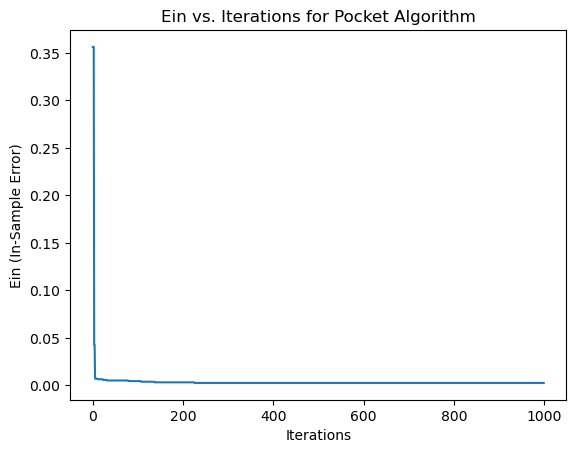

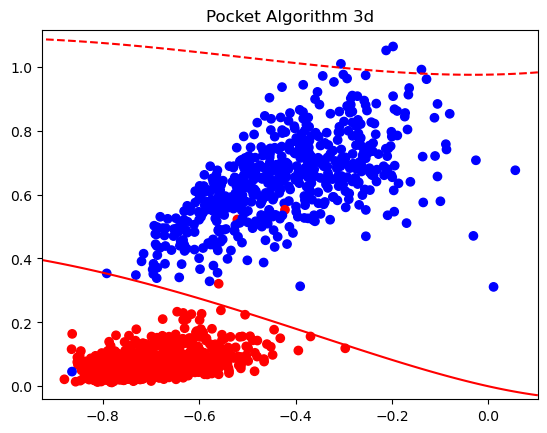

Final Weights (Pocket): (0.0, -0.7150429687499958, -2.1301796875000085, 1.5470275926055883, -0.09003207440185917, 1.3030926029358105, 0.7953896384277653, -0.36249066504817273, -0.21682397749459167, -0.49422992027442886) Number of Missclassified points: 4 , Got Final Weights at iteration 224
In sample Error: 0.25624599615631005 %


In [20]:
max_itr = 1000
w = [1]*10
w_pocket_3d = pocket_algo_3d(w)

This is the output for the Train Dataset

In [21]:
y = list(data_test.iloc[:,-1])
data_test = data_test.iloc[:,:-1]
data_test = data_test.drop(columns="x0")

data_x = np.array(data_test)
data_poly = np.c_[[1]*len(data_x), data_x, data_x[:, 0]**2, data_x[:, 1]**2, data_x[:, 0] * data_x[:, 1], data_x[:, 0]**3, data_x[:, 1]**3, data_x[:, 0]**2*data_x[:, 1], data_x[:, 1]**2*data_x[:, 0]]
data_3d = pd.DataFrame(data_poly)
data_3d.insert(data_3d.shape[1],'y',y)

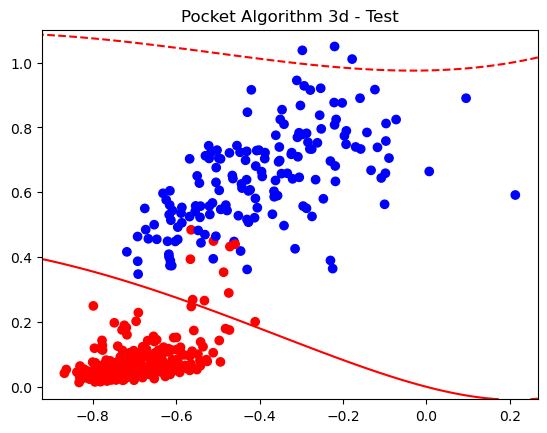

Test data in Sample Error is 2.358490566037736 %
Numnber of misclassified points: 10


In [22]:
plot10poly(w_pocket_3d, "Pocket Algorithm 3d - Test")
miss_points = check_missing_points_3d(w_pocket_3d)
ein_pocket_test = len(miss_points)/len(data)*100
print("Test data in Sample Error is", ein_pocket_test, "%")
print("Numnber of misclassified points:", len(miss_points))

This is the output for the Test Dataset.